# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



In [18]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
#% matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, median_absolute_error
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data understanding and cleaning

In [19]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [20]:
#encoding the channels in to 1s and 0s
channels = ['web', 'email', 'mobile', 'social']
for channel in channels:
    portfolio[channel] = portfolio.channels.apply(lambda x: channel in x)*1
    
#droping the channels column
portfolio.drop('channels', axis=1, inplace=True)

In [21]:
# Creating a new column in the dataframe  with concatinating the offer_type with rewards, difficulty and duration
portfolio['offer_name'] = portfolio.offer_type + "_" + portfolio.reward.astype(str) + "_" + portfolio.difficulty.astype(str) + "_" + portfolio.duration.astype(str)
portfolio.rename(columns={"id": "offer_id"}, inplace=True)

In [22]:
portfolio

,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social,offer_name
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,bogo_10_10_7
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,bogo_10_10_5
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,informational_0_0_4
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,bogo_5_5_7
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,discount_5_20_10
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,discount_3_7_7
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,discount_2_10_10
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,informational_0_0_3
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,bogo_5_5_5
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,discount_2_10_7


In [23]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [24]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [25]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [26]:
profile.isna().sum() * 100 / profile.shape[0]

gender              12.794118
age                  0.000000
id                   0.000000
became_member_on     0.000000
income              12.794118
dtype: float64

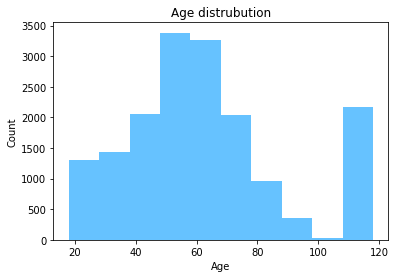

In [27]:
# ploting the age distribution in the profile data
plt.hist(data = profile , x='age',color = '#66c2ff')
plt.title('Age distrubution');
plt.xlabel('Age');
plt.ylabel('Count');

C:\Users\DELL\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\DELL\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


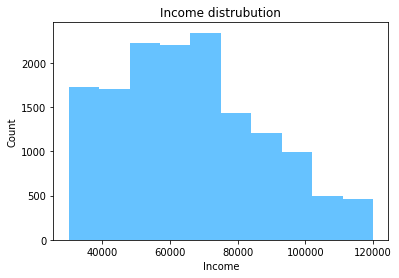

In [28]:
# ploting the income distribution in the profile data
plt.hist(data = profile , x='income',color = '#66c2ff')
plt.title('Income distrubution');
plt.xlabel('Income');
plt.ylabel('Count');

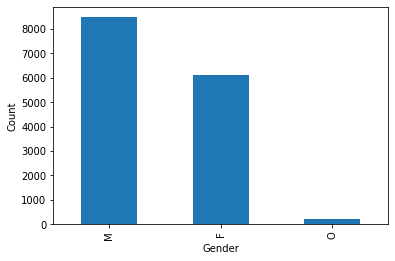

In [29]:
# ploting the gender counts
profile.gender.value_counts().plot(kind='bar')
plt.xlabel('Gender');
plt.ylabel('Count');

In [30]:
profile.id.value_counts().count()

17000

In [31]:
profile[profile['age'] >= 118].count()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

In [32]:
# converting the became_member_on column to datetime
profile['became_member_on'] = profile.became_member_on.apply(lambda x: str(x))
profile['became_member_on'] = pd.to_datetime(profile.became_member_on)
profile.rename(columns={"id": "customer_id"}, inplace=True)

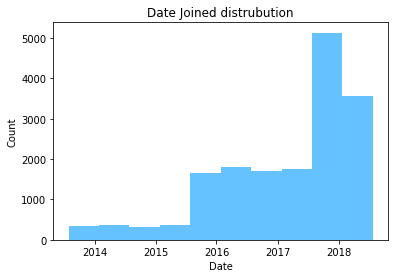

In [33]:
# ploting the date joined distribution in the profile data
plt.hist(data = profile , x='became_member_on',color = '#66c2ff')
plt.title('Date Joined distrubution');
plt.xlabel('Date');
plt.ylabel('Count');

In [34]:
profile.head()

,gender,age,customer_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [35]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [36]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [37]:
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [38]:
transcript[transcript['event'] != 'transaction']['person'].count() * 100 / transcript.shape[0]

54.66962881768417

In [39]:
transcript['time'] = transcript.time / 24.0
transcript.rename(columns={"person": "customer_id"}, inplace=True)

In [40]:
def create_offer_id_col(val):
    if list(val.keys())[0] in ['offer id', 'offer_id']:
        return list(val.values())[0]
    
def create_amount_col(val):
    if list(val.keys())[0] in ['amount']:
        return list(val.values())[0]
    
transcript['offer_id'] = transcript.value.apply(create_offer_id_col)
transcript['amount'] = transcript.value.apply(create_amount_col)
transcript.amount.astype('float')
transcript.drop(columns=['value'], inplace=True)

In [41]:
transcript

,customer_id,event,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0.00,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0.00,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,29.75,None,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,29.75,None,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,29.75,None,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,29.75,None,3.53


In [42]:
transcript.duplicated().sum()

397

In [43]:
# drop the duplicated value, and reset the index
transcript.drop_duplicates(inplace=True)
transcript.reset_index(drop=True, inplace=True)

In [44]:
transaction_df = transcript[transcript.event=='transaction'].copy()
transaction_df.drop(columns=['offer_id', 'event'], inplace=True)

In [45]:
transaction_df

,customer_id,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0.00,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.00,34.56
12659,54890f68699049c2a04d415abc25e717,0.00,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0.00,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0.00,18.97
...,...,...,...
306132,b3a1272bc9904337b331bf348c3e8c17,29.75,1.59
306133,68213b08d99a4ae1b0dcb72aebd9aa35,29.75,9.53
306134,a00058cf10334a308c68e7631c529907,29.75,3.61
306135,76ddbd6576844afe811f1a3c0fbb5bec,29.75,3.53


In [46]:
offers_df = transcript[transcript.event != 'transaction'].copy()

# one-hot encode offer event
offers_df['received'] = offers_df.event.apply(lambda x: 1 if x == 'offer received' else 0)
offers_df['completed'] = offers_df.event.apply(lambda x: 1 if x == 'offer completed' else 0)
offers_df['viewed'] = offers_df.event.apply(lambda x: 1 if x == 'offer viewed' else 0)

offers_df.drop(columns=['event', 'amount'], inplace=True)

In [47]:
offers_df

,customer_id,time,offer_id,received,completed,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0
2,e2127556f4f64592b11af22de27a7932,0.00,2906b810c7d4411798c6938adc9daaa5,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0.00,fafdcd668e3743c1bb461111dcafc2a4,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0.00,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0
...,...,...,...,...,...,...
306100,a6f84f4e976f44508c358cc9aba6d2b3,29.75,2298d6c36e964ae4a3e7e9706d1fb8c2,0,1,0
306109,b895c57e8cd047a8872ce02aa54759d6,29.75,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
306110,8dda575c2a1d44b9ac8e8b07b93d1f8e,29.75,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,1
306112,8431c16f8e1d440880db371a68f82dd0,29.75,fafdcd668e3743c1bb461111dcafc2a4,0,1,0


In [48]:
# combing the offers_df, transaction_df, portofolio and profile dataframe

data = []

#get the unique customers from the offers_df
customer_ids = offers_df['customer_id'].unique()

# loop through the customer ids in the offer dataframe
for x in range(len(customer_ids)):
    
    # get customer id from the list
    cust_id = customer_ids[x]
        
    # extract customer profile from profile data
    customer = profile[profile['customer_id'] == cust_id]
    
    # extract offers associated with the customer from offers_df
    customer_offer_data = offers_df[offers_df['customer_id'] == cust_id]
        
    # extract transactions associated with the customer from transactions_df
    customer_transaction_data = transaction_df[transaction_df['customer_id'] == cust_id]
    
    # extract received, completed, viewed offer data from customer offers
    offer_received_data = customer_offer_data[customer_offer_data['received'] == 1]
    offer_completed_data = customer_offer_data[customer_offer_data['completed'] == 1]
    offer_viewed_data = customer_offer_data[customer_offer_data['viewed'] == 1]
        
    rows = []
    # loop through each received offer
    for i in range(offer_received_data.shape[0]):
        
        # fetch an offer id 
        offer_id = offer_received_data.iloc[i]['offer_id']
         
        # extract offer row from portfolio
        offer_row = portfolio.loc[portfolio['offer_id'] == offer_id]
        
        # extract duration days of an offer from offer row
        duration_days = offer_row['duration'].values[0]
        
        # initialize start and end time of an offer
        start_time = offer_received_data.iloc[i]['time']
        end_time = start_time + duration_days
        
        # seggregate offers completed within end date
        offer_completed_withintime = np.logical_and(
            offer_completed_data['time'] >= start_time, offer_completed_data['time'] <= end_time)
    
        # seggregate offers viewed within end date
        offer_viewed_withintime = np.logical_and(
            offer_viewed_data['time'] >= start_time, offer_viewed_data['time'] <=end_time)
        
        # flag offer_successful to 1 if an offer is viewed and completed within end time else to 0
        offer_successful = offer_completed_withintime.sum() > 0 and offer_viewed_withintime.sum() > 0
        
        # flag offer_successful_without_view to 1 if an offer is not viewed and completed within end time else to 0
        offer_successful_without_view = offer_completed_withintime.sum() > 0 and  offer_viewed_withintime.sum() ==  0
        
        # extract transactions occured within time
        transaction_withintime = np.logical_and(
            customer_transaction_data['time'] >= start_time, customer_transaction_data['time'] <= end_time)
        
        #transaction data within the offer end time
        transaction_data = customer_transaction_data[transaction_withintime]
        
        # total amount spent by a customer from given offers
        transaction_total_amount = transaction_data['amount'].sum()
        
        row = {
                'offer_id': offer_id,
                'customer_id': cust_id,
                'time': start_time,
                'amount': transaction_total_amount,
                'offer_successful': int(offer_successful),
                'offer_successful_without_viewing': int(offer_successful_without_view),
            }
        
            
        row.update(offer_row.iloc[0,0:].to_dict())

        row.update(customer.iloc[0,:].to_dict())

        rows.append(row)
        
    data.extend(rows)
    
data = pd.DataFrame(data)

KeyboardInterrupt: 

In [ ]:
data

In [ ]:
data.to_csv('combined.csv', index=False)

In [49]:
data = pd.read_csv('combined.csv')
data.head()

,offer_id,customer_id,time,amount,offer_successful,offer_successful_without_viewing,reward,difficulty,duration,offer_type,web,email,mobile,social,offer_name,gender,age,became_member_on,income
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,37.67,1,0,5,5,7,bogo,1,1,1,0,bogo_5_5_7,F,75,2017-05-09,100000.0
1,5a8bc65990b245e5a138643cd4eb9837,78afa995795e4d85b5d9ceeca43f5fef,7.0,49.39,0,0,0,0,3,informational,0,1,1,1,informational_0_0_3,F,75,2017-05-09,100000.0
2,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,17.0,48.28,1,0,10,10,7,bogo,0,1,1,1,bogo_10_10_7,F,75,2017-05-09,100000.0
3,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,21.0,48.28,1,0,5,5,5,bogo,1,1,1,1,bogo_5_5_5,F,75,2017-05-09,100000.0
4,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.0,0.00,0,0,2,10,7,discount,1,1,1,0,discount_2_10_7,M,68,2018-04-26,70000.0


In [50]:
#extract the year from the date column
data['became_member_on'] = data['became_member_on'].apply(lambda x : x[0:4])

In [51]:
# removing outliers
data = data[data['age'] != 118]

In [52]:
data.age.min()

18

In [53]:
data.age.max()

101

In [54]:
# Add the age range column to group the customers in age-ranges
data['age-range'] = pd.cut(x = data['age'], 
                               bins = [17, 20, 30, 40, 50, 60, 70, 80, 90, 105],
                               labels = ['<20','21-30','31-40','41-50','51-60','61-70','71-80','81-90','>90'])

In [55]:
data.income.min()

30000.0

In [56]:
data.income.max()

120000.0

In [57]:
# Add the income range column to group the customers in income-ranges
data['income-range'] = pd.cut(x = data['income'], 
                               bins = [20000, 40000, 50000, 60000, 70000, 80000, 90000, 100000,130000],
                               labels = ['<40k','41-50k','51-60k','61-70k','71-80k','81-90k','91-100k','>100k'])

In [58]:
data.isna().sum().sum()

0

In [59]:
offers_list = []
offers_list.append(data[data['offer_id'] == 'ae264e3637204a6fb9bb56bc8210ddfd']['offer_successful'].mean() * 100)
offers_list.append(data[data['offer_id'] == '4d5c57ea9a6940dd891ad53e9dbe8da0']['offer_successful'].mean() * 100)
offers_list.append(data[data['offer_id'] == '3f207df678b143eea3cee63160fa8bed']['offer_successful'].mean() * 100)
offers_list.append(data[data['offer_id'] == '9b98b8c7a33c4b65b9aebfe6a799e6d9']['offer_successful'].mean() * 100)
offers_list.append(data[data['offer_id'] == '0b1e1539f2cc45b7b9fa7c272da2e1d7']['offer_successful'].mean() * 100)
offers_list.append(data[data['offer_id'] == '2298d6c36e964ae4a3e7e9706d1fb8c2']['offer_successful'].mean() * 100)
offers_list.append(data[data['offer_id'] == 'fafdcd668e3743c1bb461111dcafc2a4']['offer_successful'].mean() * 100)
offers_list.append(data[data['offer_id'] == '5a8bc65990b245e5a138643cd4eb9837']['offer_successful'].mean() * 100)
offers_list.append(data[data['offer_id'] == 'f19421c1d4aa40978ebb69ca19b0e20d']['offer_successful'].mean() * 100)
offers_list.append(data[data['offer_id'] == '2906b810c7d4411798c6938adc9daaa5']['offer_successful'].mean() * 100)

portfolio['completed_percent'] = offers_list

In [60]:
portfolio

,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social,offer_name,completed_percent
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,bogo_10_10_7,54.646117
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,bogo_10_10_5,51.721523
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,informational_0_0_4,7.721196
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,bogo_5_5_7,48.287210
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,discount_5_20_10,45.762712
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,discount_3_7_7,72.742299
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,discount_2_10_10,75.285628
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,informational_0_0_3,6.277284
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,bogo_5_5_5,61.618005
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,discount_2_10_7,47.730357


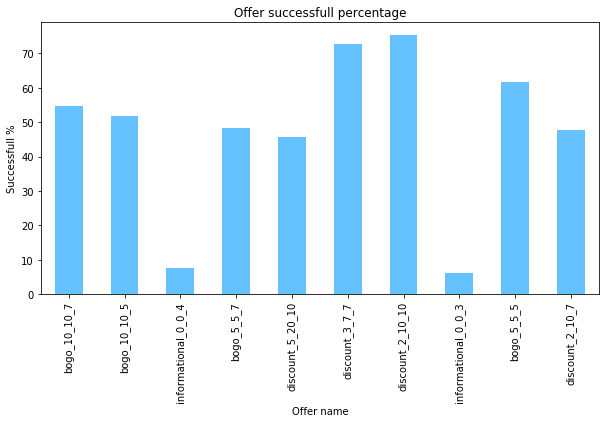

In [249]:
portfolio.plot(kind='bar', 
           x='offer_name',
           y='completed_percent',
           color = '#66c2ff', 
           figsize =(10,5), 
           title = "Offer successfull percentage", 
           legend = False);
plt.xlabel('Offer name');
plt.ylabel('Successfull %');

## Analyze Offer 1) bogo_10_10_7


In [250]:
offer1 = data[data['offer_name'] == 'bogo_10_10_7'] 
offer1 = offer1[offer1['gender'] != 'O']
offer1.head()

,offer_id,customer_id,time,amount,offer_successful,offer_successful_without_viewing,reward,difficulty,duration,offer_type,...,email,mobile,social,offer_name,gender,age,became_member_on,income,age-range,income-range
2,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,17.0,48.28,1,0,10,10,7,bogo,...,1,1,1,bogo_10_10_7,F,75,2017,100000.0,71-80,91-100k
20,ae264e3637204a6fb9bb56bc8210ddfd,aa4862eba776480b8bb9c68455b8c2e1,17.0,60.66,1,0,10,10,7,bogo,...,1,1,1,bogo_10_10_7,F,61,2017,57000.0,61-70,51-60k
28,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,0.0,0.00,0,0,10,10,7,bogo,...,1,1,1,bogo_10_10_7,M,64,2017,100000.0,61-70,91-100k
32,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,21.0,31.05,1,0,10,10,7,bogo,...,1,1,1,bogo_10_10_7,M,64,2017,100000.0,61-70,91-100k
59,ae264e3637204a6fb9bb56bc8210ddfd,1e9420836d554513ab90eba98552d0a9,0.0,0.00,0,0,10,10,7,bogo,...,1,1,1,bogo_10_10_7,M,22,2017,70000.0,21-30,61-70k


In [251]:
k=offer1.groupby(['gender','age-range'])['offer_successful'].mean().reset_index().sort_values(by='offer_successful', ascending=False).head(10)
k['offer_successful'] = k['offer_successful'] * 100
k

,gender,age-range,offer_successful
8,F,>90,67.741935
7,F,81-90,67.619048
5,F,61-70,66.501650
4,F,51-60,65.743440
3,F,41-50,65.239295
2,F,31-40,64.016736
17,M,>90,62.857143
6,F,71-80,60.714286
1,F,21-30,59.302326
16,M,81-90,57.364341


In [252]:
k=offer1.groupby(['gender','income-range'])['offer_successful'].mean().reset_index().sort_values(by='offer_successful', ascending=False).head(10)
k['offer_successful'] = k['offer_successful'] * 100
k

,gender,income-range,offer_successful
5,F,81-90k,72.598870
6,F,91-100k,72.508591
3,F,61-70k,68.103448
14,M,91-100k,68.093385
2,F,51-60k,67.488789
4,F,71-80k,65.756303
15,M,>100k,65.605096
13,M,81-90k,65.156794
7,F,>100k,64.948454
12,M,71-80k,57.317073


In [253]:
k=offer1.groupby(['gender','income-range'])['offer_successful_without_viewing'].mean().reset_index().sort_values(by='offer_successful_without_viewing', ascending=False).head(10)
k['offer_successful_without_viewing'] = k['offer_successful_without_viewing'] * 100
k

,gender,income-range,offer_successful_without_viewing
15,M,>100k,14.012739
14,M,91-100k,9.727626
4,F,71-80k,9.243697
6,F,91-100k,8.591065
7,F,>100k,8.247423
13,M,81-90k,8.013937
5,F,81-90k,7.627119
12,M,71-80k,3.861789
3,F,61-70k,2.011494
10,M,51-60k,1.517241


In [254]:
k=offer1.groupby(['gender','age-range'])['offer_successful_without_viewing'].mean().reset_index().sort_values(by='offer_successful_without_viewing', ascending=False).head(10)
k['offer_successful_without_viewing'] = k['offer_successful_without_viewing'] * 100
k

,gender,age-range,offer_successful_without_viewing
4,F,51-60,6.413994
5,F,61-70,6.270627
7,F,81-90,5.238095
8,F,>90,4.838710
13,M,51-60,4.793757
6,F,71-80,4.761905
14,M,61-70,4.390935
3,F,41-50,4.030227
15,M,71-80,3.977273
16,M,81-90,3.100775


## Analyze Offer 2) bogo_10_10_5

In [255]:
offer2 = data[data['offer_name'] == 'bogo_10_10_5'] 
offer2 = offer2[offer2['gender'] != 'O']
offer2.head()

,offer_id,customer_id,time,amount,offer_successful,offer_successful_without_viewing,reward,difficulty,duration,offer_type,...,email,mobile,social,offer_name,gender,age,became_member_on,income,age-range,income-range
18,4d5c57ea9a6940dd891ad53e9dbe8da0,aa4862eba776480b8bb9c68455b8c2e1,7.0,12.33,1,0,10,10,5,bogo,...,1,1,1,bogo_10_10_5,F,61,2017,57000.0,61-70,51-60k
37,4d5c57ea9a6940dd891ad53e9dbe8da0,c27e0d6ab72c455a8bb66d980963de60,21.0,0.00,0,0,10,10,5,bogo,...,1,1,1,bogo_10_10_5,F,78,2017,71000.0,71-80,71-80k
44,4d5c57ea9a6940dd891ad53e9dbe8da0,f806632c011441378d4646567f357a21,7.0,28.96,1,0,10,10,5,bogo,...,1,1,1,bogo_10_10_5,M,42,2013,69000.0,41-50,61-70k
50,4d5c57ea9a6940dd891ad53e9dbe8da0,d058f73bf8674a26a95227db098147b1,17.0,28.48,1,0,10,10,5,bogo,...,1,1,1,bogo_10_10_5,F,56,2018,88000.0,51-60,81-90k
60,4d5c57ea9a6940dd891ad53e9dbe8da0,1e9420836d554513ab90eba98552d0a9,7.0,35.93,1,0,10,10,5,bogo,...,1,1,1,bogo_10_10_5,M,22,2017,70000.0,21-30,61-70k


In [256]:
k=offer2.groupby(['gender','age-range'])['offer_successful'].mean().reset_index().sort_values(by='offer_successful', ascending=False).head(10)
k['offer_successful'] = k['offer_successful'] * 100
k

,gender,age-range,offer_successful
4,F,51-60,68.128655
7,F,81-90,64.893617
2,F,31-40,64.622642
3,F,41-50,63.814181
8,F,>90,63.768116
5,F,61-70,63.604853
6,F,71-80,61.432507
1,F,21-30,52.631579
15,M,71-80,52.197802
13,M,51-60,50.522648


In [257]:
k=offer2.groupby(['gender','income-range'])['offer_successful'].mean().reset_index().sort_values(by='offer_successful', ascending=False).head(10)
k['offer_successful'] = k['offer_successful'] * 100
k

,gender,income-range,offer_successful
15,M,>100k,77.419355
5,F,81-90k,72.560976
6,F,91-100k,71.379310
7,F,>100k,70.096463
4,F,71-80k,69.477912
13,M,81-90k,66.375546
14,M,91-100k,65.948276
2,F,51-60k,63.037975
3,F,61-70k,62.182741
12,M,71-80k,55.491329


In [258]:
k=offer2.groupby(['gender','age-range'])['offer_successful_without_viewing'].mean().reset_index().sort_values(by='offer_successful_without_viewing', ascending=False).head(10)
k['offer_successful_without_viewing'] = k['offer_successful_without_viewing'] * 100
k

,gender,age-range,offer_successful_without_viewing
8,F,>90,2.898551
15,M,71-80,1.923077
6,F,71-80,1.652893
5,F,61-70,1.559792
16,M,81-90,1.515152
3,F,41-50,1.466993
2,F,31-40,1.415094
4,F,51-60,1.315789
13,M,51-60,1.161440
14,M,61-70,1.112656


In [259]:
k=offer2.groupby(['gender','income-range'])['offer_successful_without_viewing'].mean().reset_index().sort_values(by='offer_successful_without_viewing', ascending=False).head(10)
k['offer_successful_without_viewing'] = k['offer_successful_without_viewing'] * 100
k

,gender,income-range,offer_successful_without_viewing
7,F,>100k,3.215434
15,M,>100k,2.580645
13,M,81-90k,2.183406
4,F,71-80k,1.807229
12,M,71-80k,1.734104
0,F,<40k,1.492537
3,F,61-70k,1.269036
2,F,51-60k,1.265823
5,F,81-90k,1.219512
14,M,91-100k,0.862069


## Analyze Offer 3) bogo_5_5_7

In [260]:
offer3 = data[data['offer_name'] == 'bogo_5_5_7'] 
offer3 = offer3[offer3['gender'] != 'O']
offer3.head()

,offer_id,customer_id,time,amount,offer_successful,offer_successful_without_viewing,reward,difficulty,duration,offer_type,...,email,mobile,social,offer_name,gender,age,became_member_on,income,age-range,income-range
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,37.67,1,0,5,5,7,bogo,...,1,1,0,bogo_5_5_7,F,75,2017,100000.0,71-80,91-100k
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,17.0,18.42,1,0,5,5,7,bogo,...,1,1,0,bogo_5_5_7,M,68,2018,70000.0,61-70,61-70k
9,9b98b8c7a33c4b65b9aebfe6a799e6d9,389bc3fa690240e798340f5a15918d5c,7.0,0.00,0,0,5,5,7,bogo,...,1,1,0,bogo_5_5_7,M,65,2018,53000.0,61-70,51-60k
11,9b98b8c7a33c4b65b9aebfe6a799e6d9,389bc3fa690240e798340f5a15918d5c,17.0,15.63,1,0,5,5,7,bogo,...,1,1,0,bogo_5_5_7,M,65,2018,53000.0,61-70,51-60k
51,9b98b8c7a33c4b65b9aebfe6a799e6d9,d058f73bf8674a26a95227db098147b1,21.0,0.00,0,0,5,5,7,bogo,...,1,1,0,bogo_5_5_7,F,56,2018,88000.0,51-60,81-90k


In [261]:
k=offer3.groupby(['gender','income-range'])['offer_successful'].mean().reset_index().sort_values(by='offer_successful', ascending=False).head(10)
k['offer_successful'] = k['offer_successful'] * 100
k

,gender,income-range,offer_successful
14,M,91-100k,61.250000
13,M,81-90k,61.111111
5,F,81-90k,61.046512
3,F,61-70k,58.885942
2,F,51-60k,58.373206
4,F,71-80k,58.212058
6,F,91-100k,56.474820
12,M,71-80k,50.408163
11,M,61-70k,49.763033
0,F,<40k,46.598639


In [262]:
k=offer3.groupby(['gender','age-range'])['offer_successful'].mean().reset_index().sort_values(by='offer_successful', ascending=False).head(10)
k['offer_successful'] = k['offer_successful'] * 100
k

,gender,age-range,offer_successful
3,F,41-50,60.994764
7,F,81-90,58.201058
6,F,71-80,56.983240
4,F,51-60,54.811715
8,F,>90,54.237288
5,F,61-70,52.542373
2,F,31-40,51.190476
13,M,51-60,48.348018
12,M,41-50,47.344461
15,M,71-80,46.898263


In [263]:
k=offer3.groupby(['gender','age-range'])['offer_successful_without_viewing'].mean().reset_index().sort_values(by='offer_successful_without_viewing', ascending=False).head(10)
k['offer_successful_without_viewing'] = k['offer_successful_without_viewing'] * 100
k

,gender,age-range,offer_successful_without_viewing
1,F,21-30,25.925926
2,F,31-40,20.238095
4,F,51-60,20.223152
5,F,61-70,18.135593
6,F,71-80,16.480447
7,F,81-90,16.402116
9,M,<20,15.652174
14,M,61-70,15.384615
15,M,71-80,14.143921
10,M,21-30,13.959391


In [264]:
k=offer3.groupby(['gender','income-range'])['offer_successful_without_viewing'].mean().reset_index().sort_values(by='offer_successful_without_viewing', ascending=False).head(10)
k['offer_successful_without_viewing'] = k['offer_successful_without_viewing'] * 100
k

,gender,income-range,offer_successful_without_viewing
15,M,>100k,30.496454
7,F,>100k,28.526646
1,F,41-50k,20.312500
0,F,<40k,19.727891
5,F,81-90k,17.732558
6,F,91-100k,17.625899
4,F,71-80k,16.424116
9,M,41-50k,16.077739
2,F,51-60k,14.114833
12,M,71-80k,14.081633


## Analyze Offer 4) bogo_5_5_5

In [265]:
offer4 = data[data['offer_name'] == 'bogo_5_5_5'] 
offer4 = offer4[offer4['gender'] != 'O']
offer4.head()

,offer_id,customer_id,time,amount,offer_successful,offer_successful_without_viewing,reward,difficulty,duration,offer_type,...,email,mobile,social,offer_name,gender,age,became_member_on,income,age-range,income-range
3,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,21.0,48.28,1,0,5,5,5,bogo,...,1,1,1,bogo_5_5_5,F,75,2017,100000.0,71-80,91-100k
8,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,0.0,9.54,1,0,5,5,5,bogo,...,1,1,1,bogo_5_5_5,M,65,2018,53000.0,61-70,51-60k
12,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,21.0,11.26,1,0,5,5,5,bogo,...,1,1,1,bogo_5_5_5,M,65,2018,53000.0,61-70,51-60k
21,f19421c1d4aa40978ebb69ca19b0e20d,aa4862eba776480b8bb9c68455b8c2e1,24.0,12.56,1,0,5,5,5,bogo,...,1,1,1,bogo_5_5_5,F,61,2017,57000.0,61-70,51-60k
68,f19421c1d4aa40978ebb69ca19b0e20d,868317b9be554cb18e50bc68484749a2,21.0,22.05,1,0,5,5,5,bogo,...,1,1,1,bogo_5_5_5,F,96,2017,89000.0,>90,81-90k


In [266]:
k=offer3.groupby(['gender','age-range'])['offer_successful'].mean().reset_index().sort_values(by='offer_successful', ascending=False).head(10)
k['offer_successful'] = k['offer_successful'] * 100
k

,gender,age-range,offer_successful
3,F,41-50,60.994764
7,F,81-90,58.201058
6,F,71-80,56.983240
4,F,51-60,54.811715
8,F,>90,54.237288
5,F,61-70,52.542373
2,F,31-40,51.190476
13,M,51-60,48.348018
12,M,41-50,47.344461
15,M,71-80,46.898263


In [267]:
k=offer3.groupby(['gender','income-range'])['offer_successful'].mean().reset_index().sort_values(by='offer_successful', ascending=False).head(10)
k['offer_successful'] = k['offer_successful'] * 100
k

,gender,income-range,offer_successful
14,M,91-100k,61.250000
13,M,81-90k,61.111111
5,F,81-90k,61.046512
3,F,61-70k,58.885942
2,F,51-60k,58.373206
4,F,71-80k,58.212058
6,F,91-100k,56.474820
12,M,71-80k,50.408163
11,M,61-70k,49.763033
0,F,<40k,46.598639


In [268]:
k=offer4.groupby(['gender','income-range'])['offer_successful_without_viewing'].mean().reset_index().sort_values(by='offer_successful_without_viewing', ascending=False).head(10)
k['offer_successful_without_viewing'] = k['offer_successful_without_viewing'] * 100
k

,gender,income-range,offer_successful_without_viewing
9,M,41-50k,2.376910
15,M,>100k,2.238806
7,F,>100k,2.215190
13,M,81-90k,1.872659
1,F,41-50k,1.762115
5,F,81-90k,1.739130
6,F,91-100k,1.655629
0,F,<40k,1.444043
14,M,91-100k,1.345291
3,F,61-70k,1.344086


In [269]:
k=offer4.groupby(['gender','age-range'])['offer_successful_without_viewing'].mean().reset_index().sort_values(by='offer_successful_without_viewing', ascending=False).head(10)
k['offer_successful_without_viewing'] = k['offer_successful_without_viewing'] * 100
k

,gender,age-range,offer_successful_without_viewing
17,M,>90,5.084746
6,F,71-80,2.240896
1,F,21-30,2.000000
14,M,61-70,1.941748
5,F,61-70,1.782531
9,M,<20,1.538462
2,F,31-40,1.421801
12,M,41-50,1.399689
10,M,21-30,1.225490
4,F,51-60,1.094391


##  Analyze Offer 5) discount_5_20_10

In [270]:
offer5 = data[data['offer_name'] == 'discount_5_20_10'] 
offer5 = offer5[offer5['gender'] != 'O']
offer5.head()

,offer_id,customer_id,time,amount,offer_successful,offer_successful_without_viewing,reward,difficulty,duration,offer_type,...,email,mobile,social,offer_name,gender,age,became_member_on,income,age-range,income-range
17,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e1,0.0,12.33,1,0,5,20,10,discount,...,1,0,0,discount_5_20_10,F,61,2017,57000.0,61-70,51-60k
22,0b1e1539f2cc45b7b9fa7c272da2e1d7,31dda685af34476cad5bc968bdb01c53,0.0,0.00,0,0,5,20,10,discount,...,1,0,0,discount_5_20_10,F,62,2016,71000.0,61-70,71-80k
29,0b1e1539f2cc45b7b9fa7c272da2e1d7,4b0da7e80e5945209a1fdddfe813dbe0,7.0,109.28,1,0,5,20,10,discount,...,1,0,0,discount_5_20_10,M,64,2017,100000.0,61-70,91-100k
30,0b1e1539f2cc45b7b9fa7c272da2e1d7,4b0da7e80e5945209a1fdddfe813dbe0,14.0,61.05,1,0,5,20,10,discount,...,1,0,0,discount_5_20_10,M,64,2017,100000.0,61-70,91-100k
39,0b1e1539f2cc45b7b9fa7c272da2e1d7,d53717f5400c4e84affdaeda9dd926b3,0.0,391.30,1,0,5,20,10,discount,...,1,0,0,discount_5_20_10,F,88,2017,53000.0,81-90,51-60k


In [271]:
k=offer4.groupby(['gender','age-range'])['offer_successful'].mean().reset_index().sort_values(by='offer_successful', ascending=False).head(10)
k['offer_successful'] = k['offer_successful'] * 100
k

,gender,age-range,offer_successful
7,F,81-90,79.411765
0,F,<20,75.000000
5,F,61-70,70.409982
8,F,>90,70.175439
4,F,51-60,69.220246
1,F,21-30,67.500000
2,F,31-40,66.350711
3,F,41-50,65.577889
6,F,71-80,64.145658
16,M,81-90,63.815789


In [272]:
k=offer4.groupby(['gender','age-range'])['offer_successful'].mean().reset_index().sort_values(by='offer_successful', ascending=False).head(10)
k['offer_successful'] = k['offer_successful'] * 100
k

,gender,age-range,offer_successful
7,F,81-90,79.411765
0,F,<20,75.000000
5,F,61-70,70.409982
8,F,>90,70.175439
4,F,51-60,69.220246
1,F,21-30,67.500000
2,F,31-40,66.350711
3,F,41-50,65.577889
6,F,71-80,64.145658
16,M,81-90,63.815789


In [273]:
k=offer5.groupby(['gender','age-range'])['offer_successful_without_viewing'].mean().reset_index().sort_values(by='offer_successful_without_viewing', ascending=False).head(10)
k['offer_successful_without_viewing'] = k['offer_successful_without_viewing'] * 100
k

,gender,age-range,offer_successful_without_viewing
17,M,>90,21.052632
8,F,>90,20.689655
7,F,81-90,18.888889
6,F,71-80,17.771883
4,F,51-60,15.915119
5,F,61-70,14.558059
1,F,21-30,14.525140
3,F,41-50,11.704835
15,M,71-80,11.227154
14,M,61-70,9.572901


In [274]:
k=offer5.groupby(['gender','income-range'])['offer_successful_without_viewing'].mean().reset_index().sort_values(by='offer_successful_without_viewing', ascending=False).head(10)
k['offer_successful_without_viewing'] = k['offer_successful_without_viewing'] * 100
k

,gender,income-range,offer_successful_without_viewing
15,M,>100k,28.571429
7,F,>100k,27.645051
6,F,91-100k,20.577617
5,F,81-90k,16.442049
4,F,71-80k,15.230461
0,F,<40k,12.374582
14,M,91-100k,11.946903
1,F,41-50k,10.756972
13,M,81-90k,9.885932
3,F,61-70k,8.988764


## Analyze  Offer 6) discount_3_7_7

In [275]:
offer6 = data[data['offer_name'] == 'discount_3_7_7'] 
offer6 = offer6[offer6['gender'] != 'O']
offer6.head()

,offer_id,customer_id,time,amount,offer_successful,offer_successful_without_viewing,reward,difficulty,duration,offer_type,...,email,mobile,social,offer_name,gender,age,became_member_on,income,age-range,income-range
15,2298d6c36e964ae4a3e7e9706d1fb8c2,2eeac8d8feae4a8cad5a6af0499a211d,7.0,2.32,0,0,3,7,7,discount,...,1,1,1,discount_3_7_7,M,58,2017,51000.0,51-60,51-60k
24,2298d6c36e964ae4a3e7e9706d1fb8c2,31dda685af34476cad5bc968bdb01c53,14.0,50.76,1,0,3,7,7,discount,...,1,1,1,discount_3_7_7,F,62,2016,71000.0,61-70,71-80k
25,2298d6c36e964ae4a3e7e9706d1fb8c2,31dda685af34476cad5bc968bdb01c53,17.0,90.75,1,0,3,7,7,discount,...,1,1,1,discount_3_7_7,F,62,2016,71000.0,61-70,71-80k
26,2298d6c36e964ae4a3e7e9706d1fb8c2,31dda685af34476cad5bc968bdb01c53,21.0,52.56,1,0,3,7,7,discount,...,1,1,1,discount_3_7_7,F,62,2016,71000.0,61-70,71-80k
62,2298d6c36e964ae4a3e7e9706d1fb8c2,1e9420836d554513ab90eba98552d0a9,17.0,32.06,1,0,3,7,7,discount,...,1,1,1,discount_3_7_7,M,22,2017,70000.0,21-30,61-70k


In [276]:
k=offer6.groupby(['gender','income-range'])['offer_successful'].mean().reset_index().sort_values(by='offer_successful', ascending=False).head(10)
k['offer_successful'] = k['offer_successful'] * 100
k

,gender,income-range,offer_successful
5,F,81-90k,84.750733
4,F,71-80k,82.352941
15,M,>100k,82.222222
6,F,91-100k,81.118881
7,F,>100k,81.034483
2,F,51-60k,79.214781
0,F,<40k,78.260870
3,F,61-70k,77.493606
13,M,81-90k,76.862745
14,M,91-100k,76.494024


In [277]:
k=offer6.groupby(['gender','age-range'])['offer_successful'].mean().reset_index().sort_values(by='offer_successful', ascending=False).head(10)
k['offer_successful'] = k['offer_successful'] * 100
k

,gender,age-range,offer_successful
2,F,31-40,83.884298
4,F,51-60,82.448378
7,F,81-90,81.151832
6,F,71-80,80.804954
5,F,61-70,79.362416
1,F,21-30,79.234973
3,F,41-50,76.849642
16,M,81-90,74.712644
8,F,>90,73.076923
12,M,41-50,71.241830


In [278]:
k=offer6.groupby(['gender','income-range'])['offer_successful_without_viewing'].mean().reset_index().sort_values(by='offer_successful_without_viewing', ascending=False).head(10)
k['offer_successful_without_viewing'] = k['offer_successful_without_viewing'] * 100
k

,gender,income-range,offer_successful_without_viewing
1,F,41-50k,2.666667
0,F,<40k,1.811594
13,M,81-90k,1.568627
7,F,>100k,1.379310
5,F,81-90k,1.173021
6,F,91-100k,1.048951
3,F,61-70k,1.023018
9,M,41-50k,1.018676
11,M,61-70k,0.934579
8,M,<40k,0.891530


In [279]:
k=offer6.groupby(['gender','age-range'])['offer_successful_without_viewing'].mean().reset_index().sort_values(by='offer_successful_without_viewing', ascending=False).head(10)
k['offer_successful_without_viewing'] = k['offer_successful_without_viewing'] * 100
k

,gender,age-range,offer_successful_without_viewing
0,F,<20,2.941176
8,F,>90,1.923077
3,F,41-50,1.670644
5,F,61-70,1.342282
2,F,31-40,1.239669
16,M,81-90,1.149425
10,M,21-30,1.111111
1,F,21-30,1.092896
7,F,81-90,1.047120
15,M,71-80,1.044386


## Analyse offer 7) discount_2_10_10

In [280]:
offer7 = data[data['offer_name'] == 'discount_2_10_10'] 
offer7 = offer7[offer7['gender'] != 'O']
offer7.head()

,offer_id,customer_id,time,amount,offer_successful,offer_successful_without_viewing,reward,difficulty,duration,offer_type,...,email,mobile,social,offer_name,gender,age,became_member_on,income,age-range,income-range
7,fafdcd668e3743c1bb461111dcafc2a4,e2127556f4f64592b11af22de27a7932,21.0,18.42,1,0,2,10,10,discount,...,1,1,1,discount_2_10_10,M,68,2018,70000.0,61-70,61-70k
13,fafdcd668e3743c1bb461111dcafc2a4,389bc3fa690240e798340f5a15918d5c,24.0,11.26,1,0,2,10,10,discount,...,1,1,1,discount_2_10_10,M,65,2018,53000.0,61-70,51-60k
16,fafdcd668e3743c1bb461111dcafc2a4,2eeac8d8feae4a8cad5a6af0499a211d,14.0,13.30,1,0,2,10,10,discount,...,1,1,1,discount_2_10_10,M,58,2017,51000.0,51-60,51-60k
23,fafdcd668e3743c1bb461111dcafc2a4,31dda685af34476cad5bc968bdb01c53,7.0,69.50,1,0,2,10,10,discount,...,1,1,1,discount_2_10_10,F,62,2016,71000.0,61-70,71-80k
27,fafdcd668e3743c1bb461111dcafc2a4,31dda685af34476cad5bc968bdb01c53,24.0,0.00,0,0,2,10,10,discount,...,1,1,1,discount_2_10_10,F,62,2016,71000.0,61-70,71-80k


In [281]:
k=offer7.groupby(['gender','income-range'])['offer_successful'].mean().reset_index().sort_values(by='offer_successful', ascending=False).head(10)
k['offer_successful'] = k['offer_successful'] * 100
k

,gender,income-range,offer_successful
7,F,>100k,90.251572
15,M,>100k,87.586207
5,F,81-90k,85.757576
13,M,81-90k,84.587814
4,F,71-80k,84.570312
2,F,51-60k,82.038835
6,F,91-100k,81.327801
12,M,71-80k,80.000000
14,M,91-100k,79.098361
1,F,41-50k,78.354978


In [282]:
k=offer7.groupby(['gender','age-range'])['offer_successful'].mean().reset_index().sort_values(by='offer_successful', ascending=False).head(10)
k['offer_successful'] = k['offer_successful'] * 100
k

,gender,age-range,offer_successful
7,F,81-90,87.134503
8,F,>90,85.937500
5,F,61-70,84.984026
2,F,31-40,83.482143
4,F,51-60,81.388889
3,F,41-50,79.945055
1,F,21-30,78.089888
6,F,71-80,77.439024
13,M,51-60,75.796930
15,M,71-80,74.550129


In [283]:
k=offer7.groupby(['gender','income-range'])['offer_successful_without_viewing'].mean().reset_index().sort_values(by='offer_successful_without_viewing', ascending=False).head(10)
k['offer_successful_without_viewing'] = k['offer_successful_without_viewing'] * 100
k

,gender,income-range,offer_successful_without_viewing
7,F,>100k,1.572327
6,F,91-100k,1.244813
9,M,41-50k,1.174497
4,F,71-80k,0.976562
5,F,81-90k,0.909091
8,M,<40k,0.727802
15,M,>100k,0.689655
12,M,71-80k,0.631579
14,M,91-100k,0.409836
13,M,81-90k,0.358423


In [284]:
k=offer7.groupby(['gender','age-range'])['offer_successful_without_viewing'].mean().reset_index().sort_values(by='offer_successful_without_viewing', ascending=False).head(10)
k['offer_successful_without_viewing'] = k['offer_successful_without_viewing'] * 100
k

,gender,age-range,offer_successful_without_viewing
17,M,>90,2.941176
7,F,81-90,2.339181
8,F,>90,1.562500
9,M,<20,0.980392
4,F,51-60,0.833333
11,M,31-40,0.801603
15,M,71-80,0.771208
12,M,41-50,0.756430
6,F,71-80,0.609756
3,F,41-50,0.549451


## Analyse Offer 8) discount_2_10_7

In [285]:
offer8 = data[data['offer_name'] == 'discount_2_10_7'] 
offer8 = offer8[offer8['gender'] != 'O']
offer8.head()

,offer_id,customer_id,time,amount,offer_successful,offer_successful_without_viewing,reward,difficulty,duration,offer_type,...,email,mobile,social,offer_name,gender,age,became_member_on,income,age-range,income-range
4,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.0,0.00,0,0,2,10,7,discount,...,1,1,0,discount_2_10_7,M,68,2018,70000.0,61-70,61-70k
10,2906b810c7d4411798c6938adc9daaa5,389bc3fa690240e798340f5a15918d5c,14.0,15.63,1,0,2,10,7,discount,...,1,1,0,discount_2_10_7,M,65,2018,53000.0,61-70,51-60k
40,2906b810c7d4411798c6938adc9daaa5,d53717f5400c4e84affdaeda9dd926b3,14.0,7.76,0,0,2,10,7,discount,...,1,1,0,discount_2_10_7,F,88,2017,53000.0,81-90,51-60k
48,2906b810c7d4411798c6938adc9daaa5,d058f73bf8674a26a95227db098147b1,7.0,27.23,1,0,2,10,7,discount,...,1,1,0,discount_2_10_7,F,56,2018,88000.0,51-60,81-90k
56,2906b810c7d4411798c6938adc9daaa5,ebe7ef46ea6f4963a7dd49f501b26779,17.0,26.62,1,0,2,10,7,discount,...,1,1,0,discount_2_10_7,M,59,2015,41000.0,51-60,41-50k


In [286]:
k=offer8.groupby(['gender','age-range'])['offer_successful'].mean().reset_index().sort_values(by='offer_successful', ascending=False).head(10)
k['offer_successful'] = k['offer_successful'] * 100
k

,gender,age-range,offer_successful
3,F,41-50,59.564165
8,F,>90,57.812500
5,F,61-70,57.365685
4,F,51-60,53.571429
2,F,31-40,50.420168
15,M,71-80,49.857550
14,M,61-70,48.671329
13,M,51-60,48.488242
7,F,81-90,47.567568
6,F,71-80,47.368421


In [287]:
k=offer8.groupby(['gender','income-range'])['offer_successful'].mean().reset_index().sort_values(by='offer_successful', ascending=False).head(10)
k['offer_successful'] = k['offer_successful'] * 100
k

,gender,income-range,offer_successful
13,M,81-90k,65.328467
5,F,81-90k,64.444444
14,M,91-100k,63.063063
6,F,91-100k,60.507246
3,F,61-70k,60.372340
2,F,51-60k,55.187638
4,F,71-80k,53.078556
12,M,71-80k,52.830189
15,M,>100k,51.034483
11,M,61-70k,46.515152


In [288]:
k=offer8.groupby(['gender','age-range'])['offer_successful_without_viewing'].mean().reset_index().sort_values(by='offer_successful_without_viewing', ascending=False).head(10)
k['offer_successful_without_viewing'] = k['offer_successful_without_viewing'] * 100
k

,gender,age-range,offer_successful_without_viewing
7,F,81-90,20.540541
0,F,<20,18.918919
6,F,71-80,18.421053
1,F,21-30,17.441860
4,F,51-60,17.285714
8,F,>90,14.062500
2,F,31-40,13.445378
14,M,61-70,13.286713
5,F,61-70,13.171577
16,M,81-90,12.949640


In [289]:
k=offer8.groupby(['gender','income-range'])['offer_successful_without_viewing'].mean().reset_index().sort_values(by='offer_successful_without_viewing', ascending=False).head(10)
k['offer_successful_without_viewing'] = k['offer_successful_without_viewing'] * 100
k

,gender,income-range,offer_successful_without_viewing
15,M,>100k,25.517241
7,F,>100k,22.522523
1,F,41-50k,18.340611
4,F,71-80k,16.985138
0,F,<40k,14.909091
5,F,81-90k,14.603175
6,F,91-100k,14.130435
2,F,51-60k,12.803532
12,M,71-80k,12.075472
14,M,91-100k,11.261261


## Analysing Best Offers for each Age-Range

In [290]:
offer_name_list = []
offers_success_list = []
age_list = []
age_range_list = data['age-range'].unique()
for i in age_range_list:
    age = data[data['age-range'] == i]
    p = age.groupby('offer_name')['offer_successful'].mean().reset_index().sort_values(ascending = False, by='offer_successful')
    p['offer_successful'] = p['offer_successful'] * 100
    offer_name_list.append(p.iloc[0].to_list()[0])
    offers_success_list.append(p.iloc[0].to_list()[1])
    age_list.append(i)
d = { 'age-range': age_list, 'offer_name': offer_name_list, 'offer_success_percent': offers_success_list}
best_offers_df = pd.DataFrame(data = d)
best_offers_df

,age-range,offer_name,offer_success_percent
0,71-80,discount_2_10_10,75.753425
1,61-70,discount_2_10_10,77.296106
2,51-60,discount_2_10_10,78.279975
3,81-90,discount_2_10_10,80.000000
4,41-50,discount_3_7_7,73.537872
5,21-30,discount_2_10_10,66.719243
6,>90,discount_2_10_10,80.612245
7,31-40,discount_2_10_10,74.557823
8,<20,discount_3_7_7,66.025641


## Analysing Best Offers for each Income-Range

In [291]:
offer_name_list = []
offers_success_list = []
income_list = []
income_range_list = data['income-range'].unique()
for i in income_range_list:
    income = data[data['income-range'] == i]
    p = income.groupby('offer_name')['offer_successful'].mean().reset_index().sort_values(ascending = False, by='offer_successful')
    p['offer_successful'] = p['offer_successful'] * 100
    offer_name_list.append(p.iloc[0].to_list()[0])
    offers_success_list.append(p.iloc[0].to_list()[1])
    income_list.append(i)
d = { 'income-range': income_list, 'offer_name': offer_name_list, 'offer_success_percent': offers_success_list}
best_offers_df = pd.DataFrame(data = d)
best_offers_df

,income-range,offer_name,offer_success_percent
0,91-100k,discount_2_10_10,80.081301
1,61-70k,discount_2_10_10,73.809524
2,51-60k,discount_2_10_10,71.885522
3,71-80k,discount_2_10_10,82.517483
4,81-90k,discount_2_10_10,85.113269
5,41-50k,discount_2_10_10,69.019139
6,<40k,discount_3_7_7,65.392562
7,>100k,discount_2_10_10,89.416847


## Analysing the offers completion rate for each age-range

In [292]:
offer_name_list = []
offers_success_list = []
year_list = []
year_range_list = data['became_member_on'].unique()
for i in year_range_list:
    year = data[data['became_member_on'] == i]
    p = year.groupby('offer_name')['offer_successful'].mean().reset_index().sort_values(ascending = False, by='offer_successful')
    p['offer_successful'] = p['offer_successful'] * 100
    offer_name_list.append(p.iloc[0].to_list()[0])
    offers_success_list.append(p.iloc[0].to_list()[1])
    year_list.append(i)
d = { 'year': year_list, 'offer_name': offer_name_list, 'offer_success_percent': offers_success_list}
best_offers_df = pd.DataFrame(data = d)
best_offers_df

,year,offer_name,offer_success_percent
0,2017,discount_2_10_10,72.910663
1,2018,discount_2_10_10,49.707260
2,2016,discount_2_10_10,96.441809
3,2013,discount_2_10_10,93.333333
4,2015,discount_2_10_10,95.718232
5,2014,discount_2_10_10,87.577640


## Analysing Offer success percentage for each age-range

In [293]:
age_list = []
offers_success_list = []
age_range_list = data['age-range'].unique()
for i in age_range_list:
    age = data[data['age-range'] == i]
    offers_success_list.append(age['offer_successful'].mean() * 100)
    age_list.append(i)
d = { 'age-range': age_list,'offer_success_percent': offers_success_list}
best_offers_df = pd.DataFrame(data = d)
best_offers_df

,age-range,offer_success_percent
0,71-80,49.086197
1,61-70,49.065993
2,51-60,49.514743
3,81-90,50.541728
4,41-50,47.873141
5,21-30,37.961165
6,>90,49.349349
7,31-40,44.029436
8,<20,34.748011


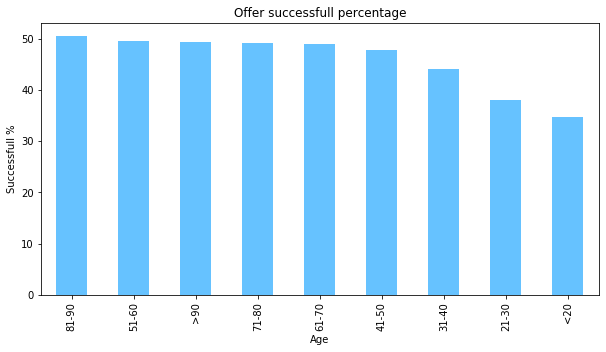

In [294]:
best_offers_df.reset_index().sort_values(by='offer_success_percent', ascending = False).plot(kind='bar', 
           x='age-range',
           y='offer_success_percent',
           color = '#66c2ff', 
           figsize =(10,5), 
           title = "Offer successfull percentage", 
           legend = False);
plt.xlabel('Age');
plt.ylabel('Successfull %');

## Analysing Offer Successful percentage for each Income-range 

In [295]:
income_list = []
offers_success_list = []
income_range_list = data['income-range'].unique()
for i in income_range_list:
    income = data[data['income-range'] == i]
    offers_success_list.append(income['offer_successful'].mean() * 100)
    income_list.append(i)
d = { 'income-range': income_list,'offer_success_percent': offers_success_list}
best_offers_df = pd.DataFrame(data = d)
best_offers_df

,income-range,offer_success_percent
0,91-100k,56.410741
1,61-70k,48.316000
2,51-60k,46.495755
3,71-80k,52.556875
4,81-90k,58.272328
5,41-50k,36.925628
6,<40k,34.860867
7,>100k,53.932833


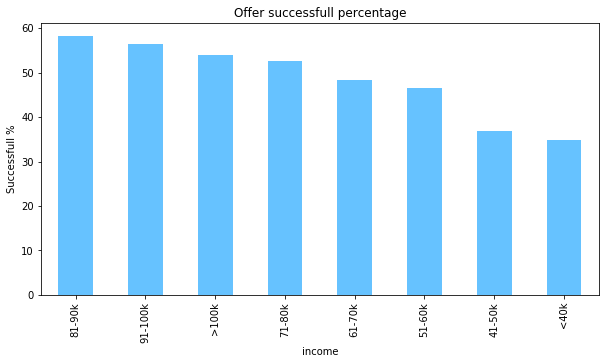

In [296]:
best_offers_df.reset_index().sort_values(by='offer_success_percent', ascending = False).plot(kind='bar', 
           x='income-range',
           y='offer_success_percent',
           color = '#66c2ff', 
           figsize =(10,5), 
           title = "Offer successfull percentage", 
           legend = False);
plt.xlabel('income');
plt.ylabel('Successfull %');

## Analysing Offers successful percentage according to the membership start year

In [297]:
year_list = []
offers_success_list = []
year_range_list = data['became_member_on'].unique()
for i in year_range_list:
    year = data[data['became_member_on'] == i]
    offers_success_list.append(year['offer_successful'].mean() * 100)
    year_list.append(i)
d = { 'year': year_list,'offer_success_percent': offers_success_list}
best_offers_df = pd.DataFrame(data = d)
best_offers_df

,year,offer_success_percent
0,2017,46.232836
1,2018,31.180711
2,2016,62.744083
3,2013,47.063622
4,2015,57.930070
5,2014,47.090481


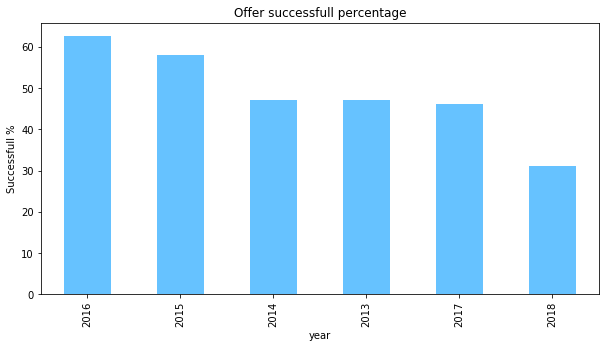

In [298]:
best_offers_df.reset_index().sort_values(by='offer_success_percent', ascending = False).plot(kind='bar', 
           x='year',
           y='offer_success_percent',
           color = '#66c2ff', 
           figsize =(10,5), 
           title = "Offer successfull percentage", 
           legend = False);
plt.xlabel('year');
plt.ylabel('Successfull %');

## Ananlysing offer successful percentage for each gender

In [299]:
gender_list = []
offers_success_list = []
gender_range_list = data['gender'].unique()
for i in gender_range_list:
    gender = data[data['gender'] == i]
    offers_success_list.append(gender['offer_successful'].mean() * 100)
    gender_list.append(i)
d = { 'gender': gender_list,'offer_success_percent': offers_success_list}
best_offers_df = pd.DataFrame(data = d)
best_offers_df

,gender,offer_success_percent
0,F,53.114073
1,M,42.678801
2,O,55.567686


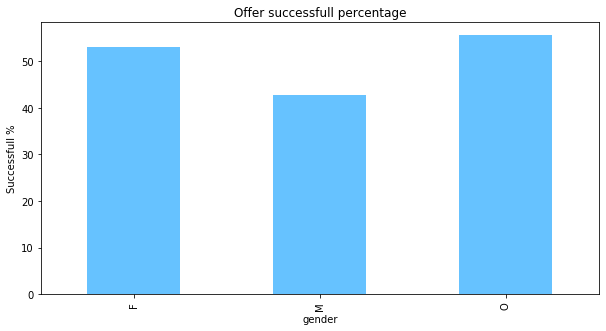

In [300]:
best_offers_df.plot(kind='bar', 
           x='gender',
           y='offer_success_percent',
           color = '#66c2ff', 
           figsize =(10,5), 
           title = "Offer successfull percentage", 
           legend = False);
plt.xlabel('gender');
plt.ylabel('Successfull %');

# Predictive Modelling

## Machine Learning  model to predict whether the offer is successfull 

In [40]:
data.columns

Index(['offer_id', 'customer_id', 'time', 'amount', 'offer_successful',
       'offer_successful_without_viewing', 'reward', 'difficulty', 'duration',
       'offer_type', 'web', 'email', 'mobile', 'social', 'offer_name',
       'gender', 'age', 'became_member_on', 'income', 'age-range',
       'income-range'],
      dtype='object')

In [41]:
X = data[['amount', 'reward', 'difficulty', 'duration', 'offer_type', 'web', 'email', 'mobile', 'social', 'gender', 
          'age', 'became_member_on', 'income']]
Y = data['offer_successful']
X.head()

,amount,reward,difficulty,duration,offer_type,web,email,mobile,social,gender,age,became_member_on,income
0,37.67,5,5,7,bogo,1,1,1,0,F,75,2017,100000.0
1,49.39,0,0,3,informational,0,1,1,1,F,75,2017,100000.0
2,48.28,10,10,7,bogo,0,1,1,1,F,75,2017,100000.0
3,48.28,5,5,5,bogo,1,1,1,1,F,75,2017,100000.0
4,0.00,2,10,7,discount,1,1,1,0,M,68,2018,70000.0


In [42]:
X.dtypes

amount              float64
reward                int64
difficulty            int64
duration              int64
offer_type           object
web                   int64
email                 int64
mobile                int64
social                int64
gender               object
age                   int64
became_member_on     object
income              float64
dtype: object

In [97]:
def clean_data(X):
    X['bogo'] = X.offer_type.apply(lambda x: 1 if x == 'bogo' else 0)
    X['discount'] = X.offer_type.apply(lambda x: 1 if x == 'discount' else 0)
    X['informational'] = X.offer_type.apply(lambda x: 1 if x == 'informational' else 0)
    X['male'] = X.gender.apply(lambda x: 1 if x == 'M' else 0)
    X['female'] = X.gender.apply(lambda x: 1 if x == 'F' else 0)
    X['other_gender'] = X.gender.apply(lambda x: 1 if x == ')' else 0)
    X['became_member_on'] = X['became_member_on'].astype(int)

    X.drop(columns=['offer_type','gender'], inplace=True)

    return X

In [44]:
X = clean_data(X)
X.head()

,amount,reward,difficulty,duration,web,email,mobile,social,age,became_member_on,income,bogo,discount,informational,male,female,other_gender
0,37.67,5,5,7,1,1,1,0,75,2017,100000.0,1,0,0,0,1,0
1,49.39,0,0,3,0,1,1,1,75,2017,100000.0,0,0,1,0,1,0
2,48.28,10,10,7,0,1,1,1,75,2017,100000.0,1,0,0,0,1,0
3,48.28,5,5,5,1,1,1,1,75,2017,100000.0,1,0,0,0,1,0
4,0.00,2,10,7,1,1,1,0,68,2018,70000.0,0,1,0,1,0,0


In [237]:
X_train, X_test, y_train, y_test = train_test_split(X,Y ,test_size=0.4, random_state=42)

## Predicting with KNeighbors Classifier

In [101]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [102]:
y_pred_training = knn.predict(X_train)

In [103]:
accuracy_score(y_pred_training, y_train) * 100

91.26817042606517

In [104]:
f1_score(y_pred_training, y_train)

0.9101922977780069

In [105]:
y_pred_test = knn.predict(X_test)

In [106]:
accuracy_score(y_pred_test, y_test) * 100

87.74482162324725

In [107]:
f1_score(y_pred_test, y_test)

0.8752009800168441

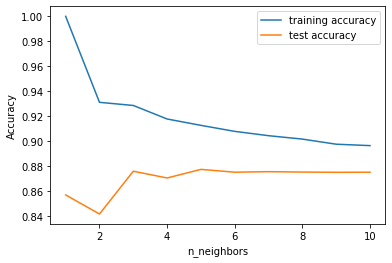

In [108]:
training_accuracy = [] 
test_accuracy = []
# try n_neighbors from 1 to 10 
neighbors_settings = range(1, 11)
for n_neighbors in neighbors_settings:
    # build the model 
    clf = KNeighborsClassifier(n_neighbors=n_neighbors) 
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend() 

In [109]:
d = { 'training_score': accuracy_score(y_pred_training, y_train) * 100 ,
     'testing_score': accuracy_score(y_pred_test, y_test) * 100,
        'best_parameter(n_neighbors)': 5}
KNeighborsClassifier_df =  pd.DataFrame(data = d, index= ['KNeighborsClassifier'])
KNeighborsClassifier_df

,training_score,testing_score,best_parameter(n_neighbors)
KNeighborsClassifier,91.26817,87.744822,5


In [368]:
KNeighborsClassifier_df.to_csv('KNeighborsClassifier_df.csv', index=False)

### Predicting with RandomForest Classifier

In [335]:
rf = RandomForestClassifier()
parameters = {'n_estimators' : [50,250,], 'max_depth':[5,10,15,20]}
        
cv = GridSearchCV(rf ,param_grid=parameters, cv=5)

In [336]:
cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [337]:
train_predict = cv.predict(X_train)
rf_train_score = accuracy_score(train_predict, y_train) * 100
rf_train_score

92.30827067669173

In [342]:
test_predict = cv.predict(X_test)
rf_test_score = accuracy_score(test_predict, y_test) * 100
rf_test_score

91.32363444983271

In [339]:
rf_f1_score = f1_score(test_predict, y_test)
rf_f1_score

0.9105495698007907

In [340]:
cv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [351]:
cv.best_params_

{'max_depth': 10, 'n_estimators': 250}

In [354]:
d = { 'training_score': rf_train_score,
     'testing_score': rf_test_score,
     'f1_score': rf_f1_score,
     'best_parameters(max_depth)': 10 ,
     'best_parameters(n_estimators)': 250 }
RandomForestClassifier_df =  pd.DataFrame(data = d, index= ['RandomForestClassifier'])
RandomForestClassifier_df

,training_score,testing_score,f1_score,best_parameters(max_depth),best_parameters(n_estimators)
RandomForestClassifier,92.308271,91.323634,0.91055,10,250


In [355]:
RandomForestClassifier_df.to_csv('RandomForestClassifier_df.csv', index=False)

### Predicting with Bagging Classifier

In [356]:
bg = BaggingClassifier(RandomForestClassifier(max_depth=10, n_estimators=250),max_samples=0.5, max_features=0.5,
                        n_estimators=100, random_state=42)

In [357]:
bg.fit(X_train, y_train)

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=10,
                                                        max_features='auto',
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        n_estimators=250,
                                                        n_jobs=None,
         

In [358]:
train_predict = bg.predict(X_train)
bc_train_score = accuracy_score(train_predict, y_train) * 100
bc_train_score

92.1328320802005

In [359]:
test_predict = bg.predict(X_test)
bc_test_score = accuracy_score(test_predict, y_test) * 100
bc_test_score

91.27476410661254

In [360]:
bc_f1_score = f1_score(test_predict, y_test)
bc_f1_score

0.9100561906607246

In [369]:
d = { 'training_score': bc_train_score,
     'testing_score': bc_test_score,
     'f1_score': bc_f1_score,
     'base_estimator': 'RandomForestClassifier' ,
     'best_parameters(max_samples)': 0.5 ,
     'best_parameters(max_features)': 0.5 ,
     'best_parameters(random_state)': 42 ,
     'best_parameters(n_estimators)': 100 }
BaggingClassifier_df =  pd.DataFrame(data = d, index= ['BaggingClassifier'])
BaggingClassifier_df

,training_score,testing_score,f1_score,base_estimator,best_parameters(max_samples),best_parameters(max_features),best_parameters(random_state),best_parameters(n_estimators)
BaggingClassifier,92.132832,91.274764,0.910056,RandomForestClassifier,0.5,0.5,42,100


In [362]:
BaggingClassifier_df.to_csv('BaggingClassifier_df.csv', index=False)

### Predicting with AdaBoost Classifier

In [363]:
ada = AdaBoostClassifier(RandomForestClassifier(max_depth=10, n_estimators=250),
                        n_estimators=10, random_state=42)

In [364]:
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=RandomForestClassifier(bootstrap=True,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=10,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         n_estimators=250,
                          

In [365]:
y_pred_training = ada.predict(X_train)
ac_train_score = accuracy_score(y_pred_training, y_train) * 100
ac_train_score

95.62406015037594

In [366]:
y_pred_testing = ada.predict(X_test)
ac_test_score = accuracy_score(y_pred_testing, y_test) * 100
ac_test_score

91.30107890680802

In [368]:
ac_f1_score = f1_score(y_pred_testing, y_test)
ac_f1_score

0.9096234963286985

In [370]:
d = { 'training_score': ac_train_score,
     'testing_score': ac_test_score,
     'f1_score': ac_f1_score,
     'base_estimator': 'RandomForestClassifier' ,
     'best_parameters(random_state)': 42 ,
     'best_parameters(n_estimators)': 10 }
AdaBoostClassifier_df =  pd.DataFrame(data = d, index= ['AdaBoostClassifier'])
AdaBoostClassifier_df

,training_score,testing_score,f1_score,base_estimator,best_parameters(random_state),best_parameters(n_estimators)
AdaBoostClassifier,95.62406,91.301079,0.909623,RandomForestClassifier,42,10


In [371]:
AdaBoostClassifier_df.to_csv('AdaBoostClassifier_df.csv', index=False)

## Most Important Features for predicting offer successfull

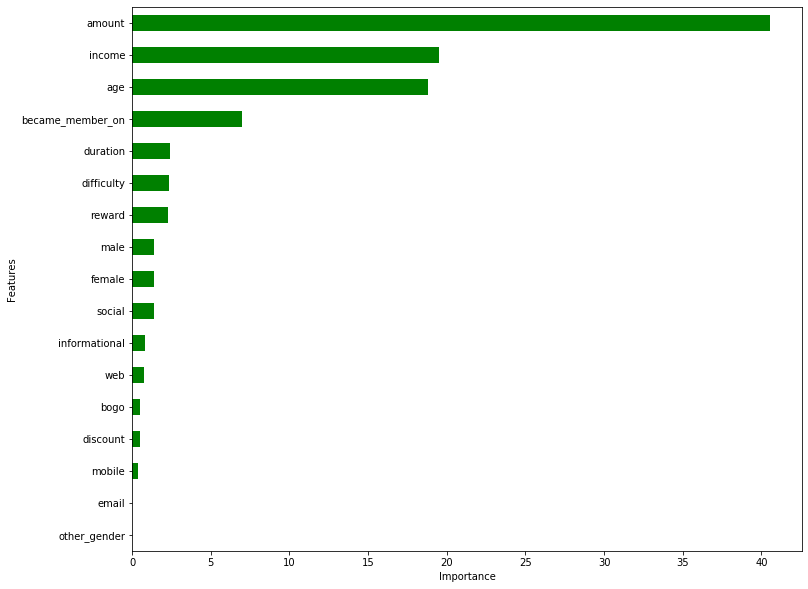

In [377]:
importances_rf = pd.Series(ada.feature_importances_, index = X.columns) 
importances_rf = importances_rf * 100
sorted_importances_rf = importances_rf.sort_values()
sorted_importances_rf.plot(kind='barh', color='green', figsize=(12,10)); 
plt.xlabel('Importance');
plt.ylabel('Features');
plt.show(); 

# Predicting how much amount will a customer spend in an offer duration period 

In [98]:
X = data[['reward', 'difficulty', 'duration', 'offer_type', 'web', 'email', 'mobile', 'social', 'gender', 
          'age', 'became_member_on', 'income','offer_successful']]
Y = data['amount']
X = clean_data(X)
X.head()

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

,reward,difficulty,duration,web,email,mobile,social,age,became_member_on,income,offer_successful,bogo,discount,informational,male,female,other_gender
0,5,5,7,1,1,1,0,75,2017,100000.0,1,1,0,0,0,1,0
1,0,0,3,0,1,1,1,75,2017,100000.0,0,0,0,1,0,1,0
2,10,10,7,0,1,1,1,75,2017,100000.0,1,1,0,0,0,1,0
3,5,5,5,1,1,1,1,75,2017,100000.0,1,1,0,0,0,1,0
4,2,10,7,1,1,1,0,68,2018,70000.0,0,0,1,0,1,0,0


In [99]:
X_train, X_test, y_train, y_test = train_test_split(X,Y ,test_size=0.4, random_state=42)

## Predicting with RandomForest Regressor

In [118]:
rfr = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=0, max_features=5)

In [119]:
rfr.fit(X_train, y_train)
train_pred = rfr.predict(X_train)
rfr_train_mean_error = mean_absolute_error(train_pred, y_train)
rfr_train_mean_error

19.063666876811904

In [120]:
rfr_train_median_error =median_absolute_error(train_pred, y_train)
rfr_train_median_error

10.252786923635163

In [121]:
rfr.fit(X_train, y_train)
pred = rfr.predict(X_test)
rfr_test_mean_error = mean_absolute_error(pred, y_test)
rfr_test_mean_error

20.122378971947928

In [122]:
rfr_test_median_error = median_absolute_error(pred, y_test)
rfr_test_median_error

10.829758617916148

In [134]:
d = { 'training_mean_absolute_error': rfr_train_mean_error,
     'training_median_absolute_error': rfr_train_median_error,
     'testing_mean_absolute_error': rfr_test_mean_error,
     'testing_median_absolute_error': rfr_test_median_error,
     'best_parameters(random_state)': 0 ,
     'best_parameters(n_estimators)': 50,
     'best_parameters(max_depth)': 10 ,
     'best_parameters(max_features)': 10 ,}
RandomForestRegressor_df =  pd.DataFrame(data = d, index= ['RandomForestRegressor_df'])
RandomForestRegressor_df

,training_mean_absolute_error,training_median_absolute_error,testing_mean_absolute_error,testing_median_absolute_error,best_parameters(random_state),best_parameters(n_estimators),best_parameters(max_depth),best_parameters(max_features)
RandomForestRegressor_df,19.063667,10.252787,20.122379,10.829759,0,50,10,10


In [135]:
RandomForestRegressor_df.to_csv('RandomForestRegressor_df.csv', index=False)

## Predicting with GradientBoosting Regressor

In [125]:
gb = GradientBoostingRegressor(n_estimators=100, max_depth=10, random_state=1, subsample=1, max_features=0.8) 

In [130]:
gb.fit(X_train, y_train)
train_pred = gb.predict(X_train)
gb_train_mean_error = mean_absolute_error(train_pred, y_train)
gb_train_mean_error

13.675590835208032

In [131]:
gb_train_median_error = median_absolute_error(train_pred, y_train)
gb_train_median_error

6.903460902143712

In [132]:
gb.fit(X_train, y_train)
pred = gb.predict(X_test)
gb_test_mean_error = mean_absolute_error(pred, y_test)
gb_test_mean_error

21.811741402070243

In [133]:
gb_test_median_error =median_absolute_error(pred, y_test)
gb_test_median_error

10.346020508398968

In [136]:
d = { 'training_mean_absolute_error': gb_train_mean_error,
     'training_median_absolute_error': gb_train_median_error,
     'testing_mean_absolute_error': gb_test_mean_error,
     'testing_median_absolute_error': gb_test_median_error,
     'best_parameters(random_state)': 1 ,
     'best_parameters(n_estimators)': 100,
     'best_parameters(max_depth)': 10 ,
      'best_parameters(subsample)': 1 ,
     'best_parameters(max_features)': 0.8 ,}
GradientBoostingRegressor =  pd.DataFrame(data = d, index= ['GradientBoostingRegressor'])
GradientBoostingRegressor

,training_mean_absolute_error,training_median_absolute_error,testing_mean_absolute_error,testing_median_absolute_error,best_parameters(random_state),best_parameters(n_estimators),best_parameters(max_depth),best_parameters(subsample),best_parameters(max_features)
GradientBoostingRegressor,13.675591,6.903461,21.811741,10.346021,1,100,10,1,0.8


In [137]:
GradientBoostingRegressor.to_csv('GradientBoostingRegressor.csv', index=False)

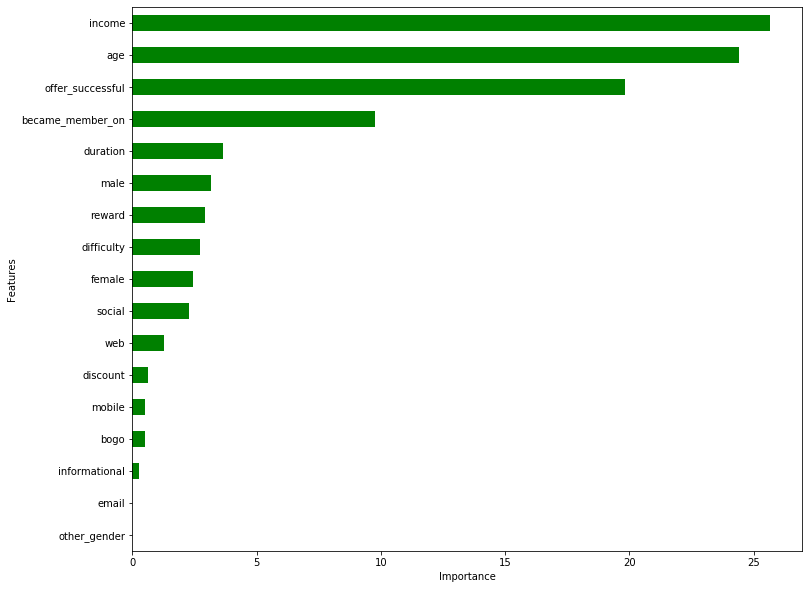

In [112]:
importances_gb = pd.Series(gb.feature_importances_, index = X.columns) 
importances_gb = importances_gb * 100
sorted_importances_gb = importances_gb.sort_values()
sorted_importances_gb.plot(kind='barh', color='green', figsize=(12,10)); 
plt.xlabel('Importance');
plt.ylabel('Features');
plt.show(); 

In [111]:
portfolio

,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social,offer_name,completed_percent
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,bogo_10_10_7,54.646117
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,bogo_10_10_5,51.721523
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,informational_0_0_4,7.721196
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,bogo_5_5_7,48.287210
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,discount_5_20_10,45.762712
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,discount_3_7_7,72.742299
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,discount_2_10_10,75.285628
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,informational_0_0_3,6.277284
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,bogo_5_5_5,61.618005
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,discount_2_10_7,47.730357
